In [2]:
import tensorflow as tf
import os

# Avoid Out of Memory Error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import cv2
import imghdr

def verify_image(image_path):
    try:
        img = cv2.imread(image_path)
        tip = imghdr.what(image_path)
    except Exception as e:
        print('Error: ' + str(e))

#data_dir = 'BM_cytomorphology_data'
data_dir = 'Data_Subset'
image_exts = ['jpg']

for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if os.path.isdir(class_path):
        for maybe_image in os.listdir(class_path):
            if os.path.isdir(os.path.join(data_dir, image_class, maybe_image)):
                for image in os.listdir(os.path.join(data_dir, image_class, maybe_image)):
                    image_path = os.path.join(data_dir, image_class, maybe_image, image)
                    verify_image(image_path)
            else:
                image_path = os.path.join(data_dir, image_class, maybe_image)
                verify_image(image_path)

Load Data

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Build data pipline
data = tf.keras.utils.image_dataset_from_directory('Data_Subset', image_size=(250, 250))
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

label_to_class_mapping = {label: class_name for label, class_name in enumerate(data.class_names)}

label_to_class_mapping

numeric_labels = batch[1]

# Convert numeric labels to class names
class_names = [label_to_class_mapping[label] for label in numeric_labels]

Found 29306 files belonging to 21 classes.


2023-11-23 14:30:17.624403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 14:30:17.624617: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-23 14:30:17.624743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

2. Preprocess Data

2.1 Scale Data

In [5]:
#Scale data from 0-255 to 0-1
data = data.map(lambda image,label: (image/255, label))
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
# data.as_numpy_iterator().next()[0].max()

2023-11-23 14:30:17.914823: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]
2023-11-23 14:30:17.916321: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]


1.0

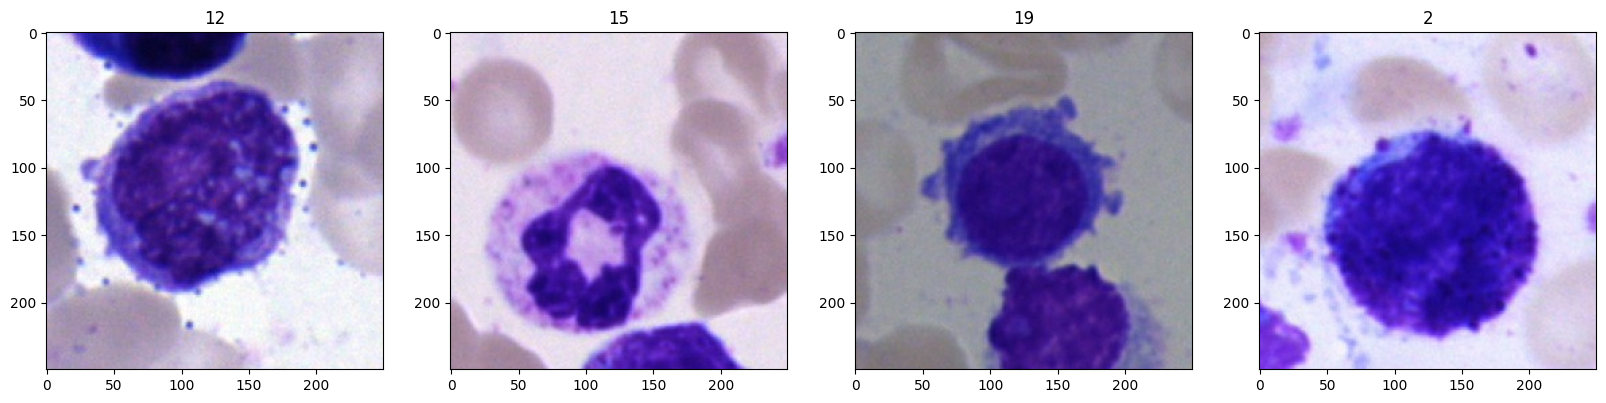

In [6]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [7]:
len(data)

916

In [8]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)

In [9]:
train_size

641

In [10]:
val_size

184

In [11]:
test_size

91

In [12]:
train_size + val_size + test_size

916

In [13]:
# How many batches we want to take for training data
train = data.take(train_size)

# Skip the batches alocated to training partition, then take the data for validation partition
val = data.skip(train_size).take(val_size)

test = data.skip(train_size + val_size).take(test_size)

3. Deep Model

3.1 Build Deep Learning Model

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()
# 16 filters, 3x3 size, stride of 1, 
model.add(Conv2D(16, (3,3), 1, activation = 'relu', input_shape = (250,250,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# Fully connected layers
model.add(Dense(250, activation = 'relu'))
model.add(Dense(21, activation='softmax')) 

In [15]:
# Uses adam optimiser
model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 16)       0

3.2 Training

In [17]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [18]:
import time

t0 = time.time()
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])
t1 = time.time()-t0

print('Training time: ', t1)

Epoch 1/20


2023-11-23 14:30:19.195968: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]
2023-11-23 14:30:19.196283: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [29306]
	 [[{{node Placeholder/_0}}]]
2023-11-23 14:30:20.114662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-11-23 14:30:20.447984: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-23

640/641 [============================>.] - ETA: 0s - loss: 2.3104 - accuracy: 0.2556

2023-11-23 14:30:36.356313: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]
2023-11-23 14:30:36.356784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]


641/641 [==============================] - 27s 38ms/step - loss: 2.3097 - accuracy: 0.2559 - val_loss: 2.0640 - val_accuracy: 0.3174
Epoch 2/20
641/641 [==============================] - 23s 36ms/step - loss: 1.8293 - accuracy: 0.4173 - val_loss: 1.7809 - val_accuracy: 0.4302
Epoch 3/20
641/641 [==============================] - 23s 36ms/step - loss: 1.5317 - accuracy: 0.5120 - val_loss: 1.6979 - val_accuracy: 0.4597
Epoch 4/20
641/641 [==============================] - 23s 36ms/step - loss: 1.2711 - accuracy: 0.5898 - val_loss: 1.7188 - val_accuracy: 0.4630
Epoch 5/20
641/641 [==============================] - 23s 36ms/step - loss: 1.0078 - accuracy: 0.6740 - val_loss: 2.0267 - val_accuracy: 0.4292
Epoch 6/20
641/641 [==============================] - 23s 36ms/step - loss: 0.7569 - accuracy: 0.7555 - val_loss: 2.2629 - val_accuracy: 0.4383
Epoch 7/20
641/641 [==============================] - 25s 38ms/step - loss: 0.5300 - accuracy: 0.8304 - val_loss: 2.6427 - val_accuracy: 0.4346
Epo

3.3 Plot Performance

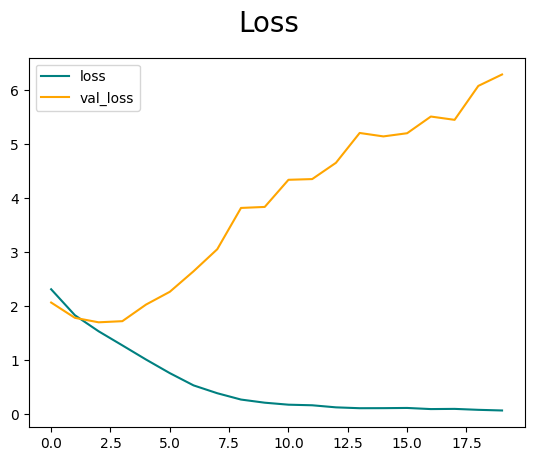

In [19]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

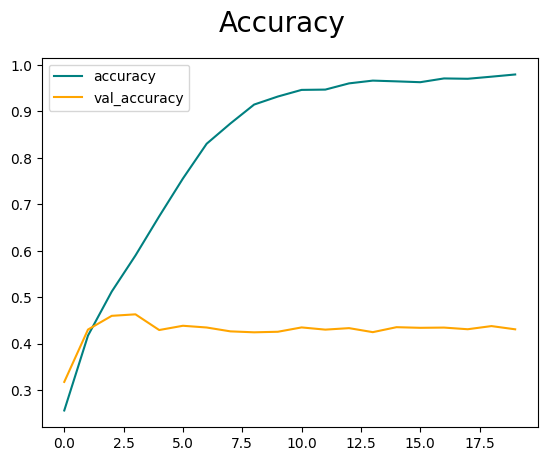

In [20]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [21]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [22]:
precision_per_class = [tf.keras.metrics.Precision(class_id=i) for i in range(21)]
recall_per_class = [tf.keras.metrics.Recall(class_id=i) for i in range(21)]
accuracy_per_class = [tf.keras.metrics.BinaryAccuracy(threshold=0.0) for _ in range(21)]

In [23]:
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))

2023-11-23 14:38:22.933784: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]
2023-11-23 14:38:22.934150: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [29306]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 172ms/step


In [26]:
from sklearn.metrics import classification_report

print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = [label_to_class_mapping[label] for label in sorted(label_to_class_mapping.keys())]

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.4230358898639679, Recall:0.40949758887290955, Accuracy:0.9452856183052063
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         0
         ART       0.45      0.47      0.46       180
         BAS       0.08      0.04      0.05        57
         BLA       0.46      0.27      0.34       221
         EBO       0.65      0.48      0.55       187
         EOS       0.46      0.49      0.48       180
         FGC       0.00      0.00      0.00         5
         HAC       0.20      0.07      0.10        46
         KSC       0.00      0.00      0.00         7
         LYI       0.00      0.00      0.00         6
         LYT       0.53      0.45      0.48       194
         MMZ       0.27      0.21      0.24       217
         MON       0.28      0.25      0.27       186
         MYB       0.24      0.32      0.28       217
         NGB       0.36      0.29      0.32       204
         NGS       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


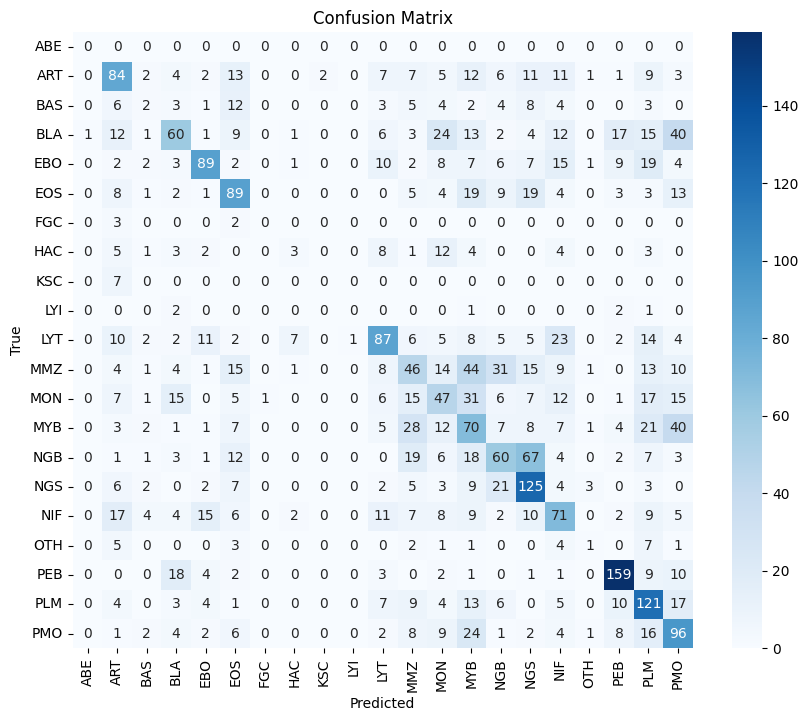

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

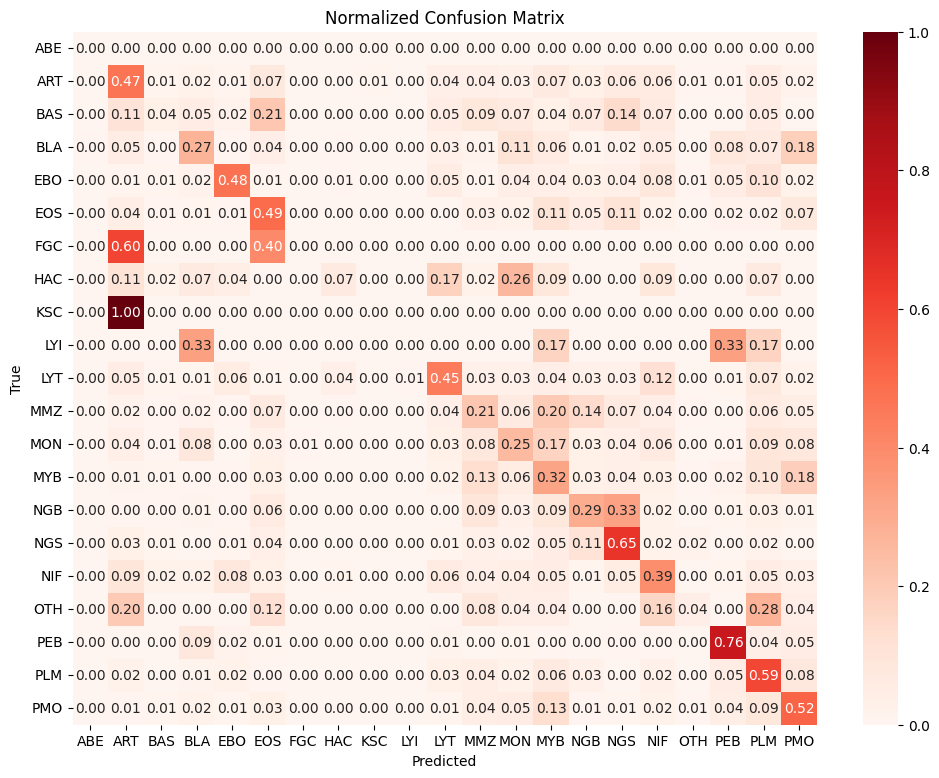

In [28]:
class_totals = np.sum(conf_matrix, axis=1)

normalized_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalized_conf_matrix[i, :] = conf_matrix[i, :] / class_totals[i]

# Plot the normalized confusion matrix with class names as tick labels
plt.figure(figsize=(12, 9))
sns.heatmap(normalized_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

4.2 Test

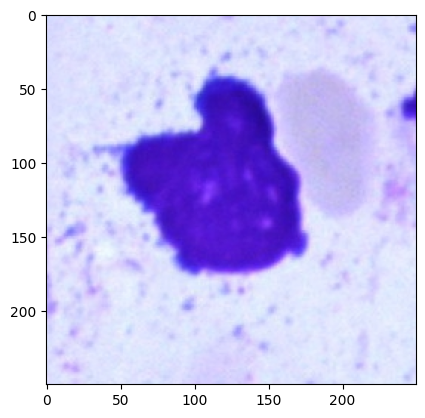

In [29]:
img = cv2.imread('ART_19001.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

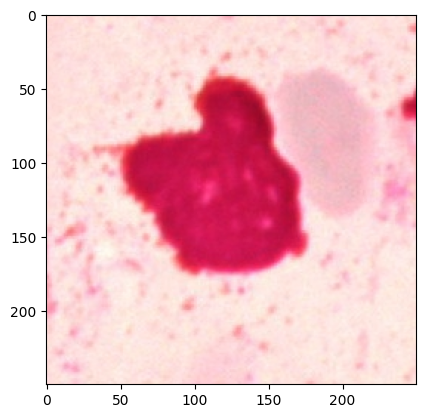

In [30]:
resize = tf.image.resize(img, (250,250))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
# Model usually predicts multiple images, np.expand_dims encapsulates it into a list
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 40ms/step


In [32]:
yhat
max_index = np.argmax(yhat)
print(label_to_class_mapping.get(max_index))

ART


5. Save the model

In [33]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models', 'first_model_copy.h5'))

In [34]:
# Reload model
new_model = load_model(os.path.join('models', 'first_model_copy.h5'))